# Taxicab Data Wrangling

This notebook explains the methodology behind the final csv used in for modeling against the S&P500. Each step is explained, section by section with markdown. At the end of the notebook I have the completed wrangle function that creates the aggregated dataset used for modeling. 

In [2]:
import pandas as pd
import numpy as np

## Introduction to the Data

Each month of NYC Yellow Taxicab data provides 10-20 million rides. This dataset would not be viable for analysis over a 5-10 year range. Instead, I will aggregate the data based on key metrics, so that each day matches up with a trading day on the S&P500. 

In [3]:
df = pd.read_csv('https://s3.amazonaws.com/nyc-tlc/trip+data/yellow_tripdata_2012-01.csv')

In [4]:
print(df.info(),'\n')
print('DataFrame Shape:\n',
      df.shape,'\n\n')
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14969132 entries, 0 to 14969131
Data columns (total 18 columns):
vendor_id             object
pickup_datetime       object
dropoff_datetime      object
passenger_count       int64
trip_distance         float64
pickup_longitude      float64
pickup_latitude       float64
rate_code             int64
store_and_fwd_flag    object
dropoff_longitude     float64
dropoff_latitude      float64
payment_type          object
fare_amount           float64
surcharge             float64
mta_tax               float64
tip_amount            float64
tolls_amount          float64
total_amount          float64
dtypes: float64(11), int64(2), object(5)
memory usage: 2.0+ GB
None 

DataFrame Shape:
 (14969132, 18) 




,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,rate_code,store_and_fwd_flag,dropoff_longitude,dropoff_latitude,payment_type,fare_amount,surcharge,mta_tax,tip_amount,tolls_amount,total_amount
0,CMT,2012-01-10 23:55:50,2012-01-11 00:03:39,1,1.7,-73.994693,40.725031,1,N,-73.975951,40.730781,CRD,6.9,0.5,0.5,1.00,0.0,8.90
1,CMT,2012-01-11 19:18:25,2012-01-11 19:26:10,1,1.1,-73.987955,40.752947,1,N,-73.994532,40.761040,CSH,6.1,1.0,0.5,0.00,0.0,7.60
2,CMT,2012-01-11 19:19:19,2012-01-11 19:48:15,2,18.0,-73.783093,40.648550,2,N,-73.996134,40.747624,CRD,45.0,0.0,0.5,10.06,4.8,60.36
3,CMT,2012-01-11 19:19:21,2012-01-11 19:27:00,1,1.7,-73.967515,40.758454,1,N,-73.956583,40.779903,CRD,6.9,1.0,0.5,1.00,0.0,9.40
4,CMT,2012-01-11 14:38:15,2012-01-11 14:43:51,1,1.2,-74.011315,40.711449,1,N,-74.002872,40.728131,CSH,5.7,0.0,0.5,0.00,0.0,6.20


In [5]:
df.isnull().sum()

vendor_id                   0
pickup_datetime             0
dropoff_datetime            0
passenger_count             0
trip_distance               0
pickup_longitude            0
pickup_latitude             0
rate_code                   0
store_and_fwd_flag    7315914
dropoff_longitude          31
dropoff_latitude           31
payment_type                0
fare_amount                 0
surcharge                   0
mta_tax                     0
tip_amount                  0
tolls_amount                0
total_amount                0
dtype: int64

### Datatime Manipulation

First we need to handle some datetime transformations. This will create columns for easy aggregation. It will also root out issues with data entry. 

I also want to create a time-delta column that accounts for the length of the ride as well as the speed/distance calculation.


In [6]:
# datetime transformation
df['pickup_datetime'] = pd.to_datetime(df['pickup_datetime'])
df['dropoff_datetime'] = pd.to_datetime(df['dropoff_datetime'])

In [7]:
# time delta calculation
df['ride_length'] =((df['dropoff_datetime'] - df['pickup_datetime'])
                    .apply(lambda x:x.total_seconds()))

In [8]:
df['trip_distance_ph'] = df['trip_distance']/(df['ride_length']/3600)

In [9]:
df['pickup_day'] = (df['pickup_datetime']
                    .map(lambda x:x.strftime('%d'))
                    .astype(int))

### Low Cardinality Ordinal Data

Let's take a look at the non-numeric data to determine if there are example where one-hot encoding would be viable. 

In [72]:
cat_vars = df.select_dtypes(exclude='number').columns.values

# get a look at my categorical variables
for cat in cat_vars:
    print(cat)
    print(df[cat].nunique(),'\n')

**Irrelevant Datatypes:**
- vendor_id
- pickup_datetime
- dropoff_datetime 

**Relevant Datatypes:**
- store_and_fwd_flag 
- payment_type

Of the relevant datatypses, 
>_store_and_fwd_flag_ indicates whether the trip record was held in vehicle memory before sending to the vendor because the vehicle did not have a connection to the server. Y=store and forward; N=not a store and forward trip. This contains a large amount of null values and is generally not useful for our model. 

> _payment_type_ provides the method for payment 


**This can be encoded with one-hot and then aggregated with a count function.**



In [77]:
df['payment_type'].unique()

array(['CRD', 'CSH', 'DIS', 'NOC'], dtype=object)

In [95]:
df3[' payment_type'].unique()

array(['CRD', 'CSH', 'UNK', 'NOC', 'DIS'], dtype=object)

### Clustering by Location

Dropoff and Pickup Location are important characteristics to account for as well. To generalize the location effectively, some kind of clustering algorithm needs to be utilized. K-Means is effect for Euclidean space, but may not be as effective for geographic clustering. A variety of methods will be tested to determine the best clusetering algorithm to utilize.

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import zscore

# Removing null values that will get in the way of outlier removal. 
df = df.dropna(subset=['pickup_longitude',
                       'pickup_latitude',
                       'dropoff_longitude',
                       'dropoff_latitude'])

# Finding Zscores for outlier removal
df['plong_z'] = np.abs(zscore(df['pickup_longitude']))
df['plat_z'] = np.abs(zscore(df['pickup_latitude']))
df['dlong_z'] = np.abs(zscore(df['dropoff_longitude']))
df['dlat_z'] = np.abs(zscore(df['dropoff_latitude']))

# Getting rid of bad lat and long values
df = df.loc[(df['plong_z'] < 0.09) & 
           (df['plat_z'] < 0.1) & 
           (df['dlong_z'] < 0.08) & 
           (df['dlat_z'] < 0.1)]

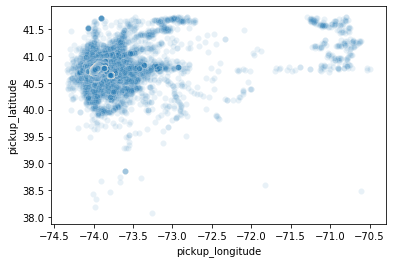

In [99]:
# pickup locations
ax = sns.scatterplot(x="pickup_longitude", 
                     y="pickup_latitude", 
                     data=df, 
                     alpha=0.1)


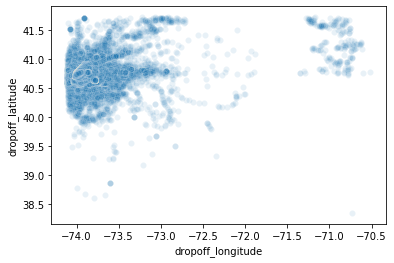

In [100]:
# dropoff locations
ax = sns.scatterplot(x="dropoff_longitude", 
                     y="dropoff_latitude", 
                     data=df, 
                     alpha=0.1)

I looks like there were quite a few rides outside of manhattan, including several going all the way out to Rhode Island. I wanto to center in on manhattan specifically. 

(39.8, 42)

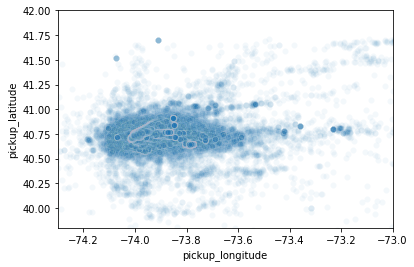

In [104]:
# pickup locations
ax = sns.scatterplot(x="pickup_longitude", 
                     y="pickup_latitude", 
                     data=df, 
                     alpha=0.05)
ax.set_xlim([-74.3 ,-73])
ax.set_ylim([39.8, 42])

(40.25, 41.2)

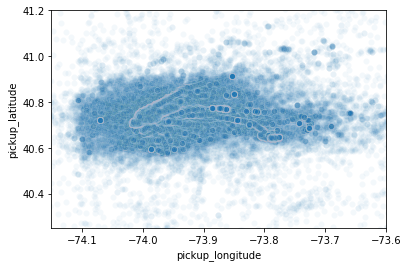

In [105]:
# pickup locations
ax = sns.scatterplot(x="pickup_longitude", 
                     y="pickup_latitude", 
                     data=df, 
                     alpha=0.05)
ax.set_xlim([-74.15 ,-73.6])
ax.set_ylim([40.25, 41.2])

The manhattan cluster is densely packed, so it might require some brute force for finding the optimal number of clusters. I'll start with an elbow curve to try to get an idea for the shape of possible clustering. 

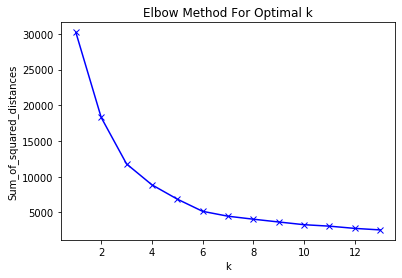

In [13]:
Sum_of_squared_distances = []
K = range(1,14)

for k in K:
    print(k)
    km = KMeans(n_clusters=k, n_jobs=-1, random_state = 42, verbose=10)
    km = km.fit(df[['pickup_longitude','pickup_latitude']])
    Sum_of_squared_distances.append(km.inertia_)
    
K = range(1,14)
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

It appears that our optimal number of clusters is 6

In [15]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=6, n_jobs=-1)
kmeans.fit(df[['pickup_longitude','pickup_latitude']])
y_kmeans = kmeans.predict(df[['pickup_longitude','pickup_latitude']])

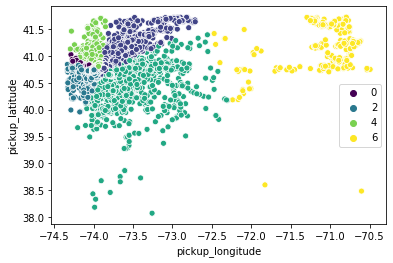

In [16]:
ax = sns.scatterplot(x=df['pickup_longitude'], 
                     y=df['pickup_latitude'], 
                     hue=y_kmeans, 
                     palette='viridis')

(40.25, 41.2)

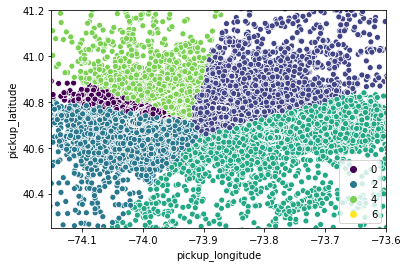

In [17]:
ax = sns.scatterplot(x=df['pickup_longitude'], 
                     y=df['pickup_latitude'], 
                     hue=y_kmeans, 
                     palette='viridis')
ax.set_xlim([-74.15 ,-73.6])
ax.set_ylim([40.25, 41.2])

In [ ]:
from sklearn.cluster import DBSCAN

db = DBSCAN(eps=3, )

In [97]:
urls = pd.read_csv('to_download.txt', 
               sep=" ",
               header=None)

In [116]:
count = 0
for url in urls.sort_values(by=0)[0].values:
    print('##########', url[-11:-4], 'Added ##########')
    test = pd.read_csv(url).head()
    test_cols = test.columns
    print(len(test_cols),'\n',
          test_cols)
    if count==0:
        pass
    else:
        print(test_cols==oldtest)


    oldtest = test_cols
    count+=1

########## 2009-01 Added ##########


KeyboardInterrupt: 